# Bibliotecas

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn import svm
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import time 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import svm
import xgboost as xgb
import warnings


print("Todas as bibliotecas foram importadas com sucesso!")


Todas as bibliotecas foram importadas com sucesso!


In [2]:
#Importando os dados
dados_vendas = pd.read_csv('dados\ecommerce_customer_data_custom_ratios.csv', low_memory=False)

# Visualizando as primeiras linhas do dataset
dados_vendas.head()


,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,1


# Dicionário:

* Customer ID: Identificação única do cliente.
* Purchase Date: Data e hora da compra.
* Product Category: Categoria do produto comprado.
* Product Price: Preço unitário do produto.
* Quantity: Quantidade de produtos comprados.
* Total Purchase Amount: Valor total da compra.
* Payment Method: Método de pagamento utilizado para a compra.
* Customer Age: Idade do cliente.
* Returns: Número de devoluções realizadas pelo cliente.
* Customer Name: Nome do cliente.
* Age: Idade do cliente (outra representação).
* Gender: Gênero do cliente.
* Churn: Indica se o cliente cancelou ou não o serviço/produto.

# Análise Exploratória

In [3]:
# Shape dos dados
dados_vendas.shape

(250000, 13)

In [4]:
# Tipos dos Dados
dados_vendas.dtypes

Customer ID                int64
Purchase Date             object
Product Category          object
Product Price              int64
Quantity                   int64
Total Purchase Amount      int64
Payment Method            object
Customer Age               int64
Returns                  float64
Customer Name             object
Age                        int64
Gender                    object
Churn                      int64
dtype: object

In [5]:
# Contar atributos categóricos (tipo object)
num_categoricos = len(dados_vendas.select_dtypes(include=['object']).columns)

# Contar atributos numéricos (excluindo 'object')
num_numericos = len(dados_vendas.columns) - num_categoricos

print("Número de atributos categóricos:", num_categoricos)
print("Número de atributos numéricos:", num_numericos)


Número de atributos categóricos: 5
Número de atributos numéricos: 8


In [6]:
#Verificação de valores faltantes
print(dados_vendas.isna().sum())

Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47596
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64


In [7]:
# Removendo as linhas com os valores faltantes
dados_vendas.dropna(inplace = True)

In [8]:
#Verificação de valores faltantes
print(dados_vendas.isna().sum())

Customer ID              0
Purchase Date            0
Product Category         0
Product Price            0
Quantity                 0
Total Purchase Amount    0
Payment Method           0
Customer Age             0
Returns                  0
Customer Name            0
Age                      0
Gender                   0
Churn                    0
dtype: int64


In [9]:
# Shape dos dados
dados_vendas.shape

(202404, 13)

In [10]:
dados_vendas.nunique()

Customer ID               49139
Purchase Date            202223
Product Category              4
Product Price               491
Quantity                      5
Total Purchase Amount      5244
Payment Method                4
Customer Age                 53
Returns                       2
Customer Name             39547
Age                          53
Gender                        2
Churn                         2
dtype: int64

In [11]:
# Convertendo as colunas para inteiros

dados_vendas['Churn'] = dados_vendas['Churn'].astype(int)
dados_vendas['Returns'] = dados_vendas['Returns'].astype(int)


In [12]:
# Tipos dos Dados
dados_vendas.dtypes

Customer ID               int64
Purchase Date            object
Product Category         object
Product Price             int64
Quantity                  int64
Total Purchase Amount     int64
Payment Method           object
Customer Age              int64
Returns                   int32
Customer Name            object
Age                       int64
Gender                   object
Churn                     int32
dtype: object

In [13]:
# Visualizando as primeiras linhas do dataset
dados_vendas.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0,Christine Hernandez,37,Male,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0,Christine Hernandez,37,Male,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0,Christine Hernandez,37,Male,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0,Christine Hernandez,37,Male,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0,James Grant,49,Female,1


# Divisão das variáveis continuas e categóricas, para uma melhor visualização trataremos as variáveis com menos de 30 entradas únicas como categóricas.

In [14]:

#Criando uma Cópia do dataset original
df = dados_vendas.copy()

# Listas para variáveis contínuas e categóricas
continuous = []
categorical = []

# Separando as colunas 
for c in df.columns:
    if df.nunique()[c] >= 30 and c != 'Customer Name':
        continuous.append(c)
    else:
        categorical.append(c)

print("Variáveis Contínuas:", continuous)
print("Variáveis Categóricas:", categorical)

Variáveis Contínuas: ['Customer ID', 'Purchase Date', 'Product Price', 'Total Purchase Amount', 'Customer Age', 'Age']
Variáveis Categóricas: ['Product Category', 'Quantity', 'Payment Method', 'Returns', 'Customer Name', 'Gender', 'Churn']


In [15]:
# Visualizando as primeiras linhas do dataset
df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0,Christine Hernandez,37,Male,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0,Christine Hernandez,37,Male,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0,Christine Hernandez,37,Male,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0,Christine Hernandez,37,Male,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0,James Grant,49,Female,1


In [16]:
continuous

['Customer ID',
 'Purchase Date',
 'Product Price',
 'Total Purchase Amount',
 'Customer Age',
 'Age']

In [17]:
# Variáveis contínuas

df[continuous].head()

,Customer ID,Purchase Date,Product Price,Total Purchase Amount,Customer Age,Age
0,46251,2020-09-08 09:38:32,12,740,37,37
1,46251,2022-03-05 12:56:35,468,2739,37,37
2,46251,2022-05-23 18:18:01,288,3196,37,37
3,46251,2020-11-12 13:13:29,196,3509,37,37
4,13593,2020-11-27 17:55:11,449,3452,49,49


In [18]:
# Variáveis categóricas
df[categorical].head()

,Product Category,Quantity,Payment Method,Returns,Customer Name,Gender,Churn
0,Electronics,3,Credit Card,0,Christine Hernandez,Male,0
1,Home,4,PayPal,0,Christine Hernandez,Male,0
2,Home,2,PayPal,0,Christine Hernandez,Male,0
3,Clothing,1,PayPal,0,Christine Hernandez,Male,0
4,Home,1,Credit Card,0,James Grant,Female,1


         Customer ID  Product Price       Quantity  Total Purchase Amount  \
count  202404.000000  202404.000000  202404.000000          202404.000000   
mean    25013.981962     254.377423       2.999269            2725.130813   
std     14412.553209     141.565500       1.414437            1441.540074   
min         1.000000      10.000000       1.000000             101.000000   
25%     12546.750000     132.000000       2.000000            1479.000000   
50%     25018.500000     254.000000       3.000000            2725.500000   
75%     37511.000000     377.000000       4.000000            3970.250000   
max     50000.000000     500.000000       5.000000            5350.000000   

        Customer Age        Returns            Age          Churn  
count  202404.000000  202404.000000  202404.000000  202404.000000  
mean       43.926498       0.497861      43.926498       0.199423  
std        15.354491       0.499997      15.354491       0.399568  
min        18.000000       0.00000

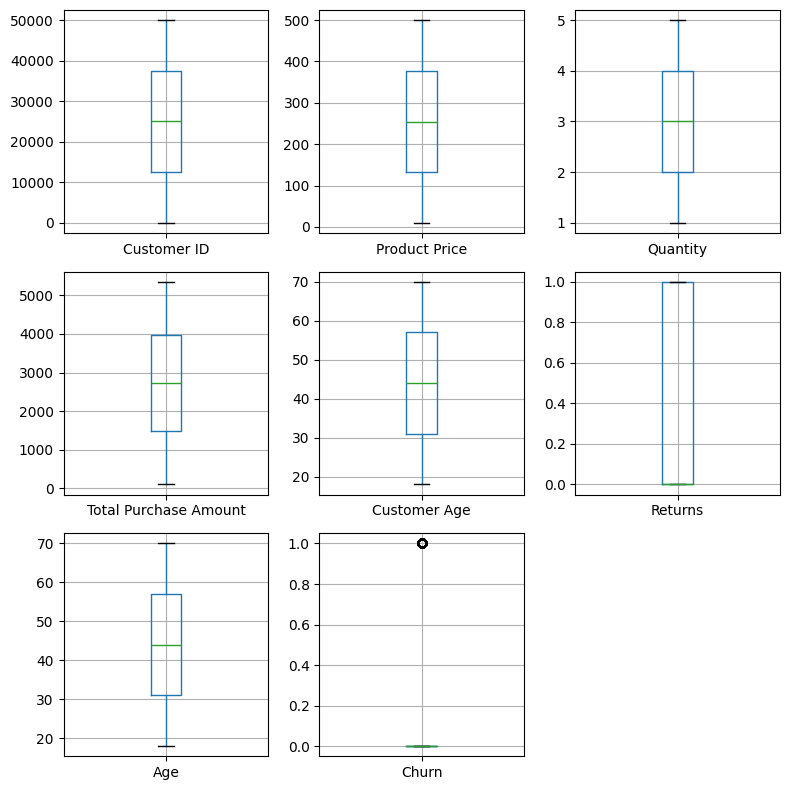

In [19]:
# Plot das variáveis contínuas

# Tamanho da área de plotagem
fig = plt.figure(figsize = (8,8))

continuous = ['Customer ID', 'Product Price', 'Quantity', 'Total Purchase Amount', 'Customer Age', 'Returns', 'Age', 'Churn']


# Loop pelas variáveis contínuas
for i, col in enumerate(continuous):
  plt.subplot (3, 3, i + 1);
  df.boxplot(col);
  plt.tight_layout()

# Salvar a Imagem do Boxplot
plt.savefig('boxplot1.png')

descriptive_stats = df[continuous].describe()
print(descriptive_stats)


Com os resultados do Boxplot podemos avaliar algumas coisas:

Perfil do Cliente:

* Faixa etária predominante: 31 a 57 anos, com média de 43 anos.
* Público-alvo: mais maduro.

Preços dos Produtos:

* Média de preço: 254.
* Variedade de produtos: de baixo custo a itens caros.

Comportamento de Compra:

* Média de unidades por compra: 3.
* Variação significativa nos valores de compra, indicando diferentes padrões de consumo.

Devoluções:

* Metade das transações resultam em devoluções, sugerindo uma política de devolução bastante utilizada.

Churn:

* Taxa de cancelamento: 20%, indicando que 1 em cada 5 clientes cancela, um ponto crítico para retenção.

Conclusões:

Perfil do Cliente: Adultos de meia-idade com comportamento de compra diversificado.

Desafios e Oportunidades: Alta taxa de devoluções e cancelamentos, áreas para melhorias em políticas de devolução e estratégias de retenção de clientes.

Estratégias de Negócio:Reduzir razões para devoluções e cancelamentos.
Personalizar ofertas para diferentes segmentos etários e comportamentais para aumentar satisfação e fidelidade.

### Matriz de correlação entre variáveis contínuas.

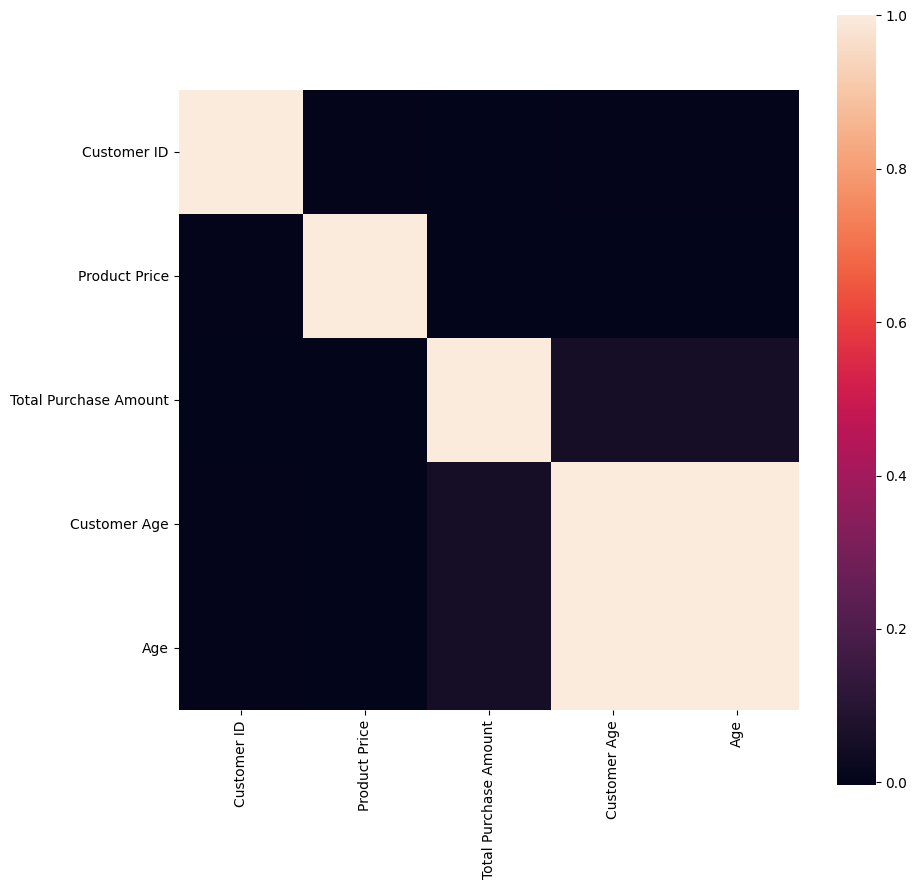

<Figure size 640x480 with 0 Axes>

In [20]:
# Área de plotagem
plt.figure(figsize=(10, 10))

# Matriz de Correlação
sns.heatmap(df[['Customer ID',
                'Product Price',
                'Total Purchase Amount',
                'Customer Age',
                'Age']].corr(), vmax=1., square=True)
plt.show()

# Salvar a Imagem do Boxplot
plt.savefig('Matriz de Correlação.png')



### Após analisarmos a matriz de correlação é possível identificar

* Customer ID: Não mostra correlação significativa com outras variáveis.
* Product Price: Não está linearmente relacionado com outras variáveis.
* Total Purchase Amount: Tem uma correlação fraca e positiva com Customer Age e Age (0.063), sugerindo que clientes ligeiramente mais velhos podem gastar um pouco mais.
* Customer Age e Age: São idênticas (correlação perfeita de 1.000), indicando que uma dessas colunas é redundante.

Conclusões:
Não há fortes relações lineares entre a maioria das variáveis analisadas a única exceção é a duplicação de Customer Age e Age e As variáveis analisadas podem ser consideradas independentes entre si, exceto pela redundância mencionada.

In [21]:
#Remoção da Coluna Redundante e Colunas Sem Uso
df = df.drop(columns='Customer Age')
df = df.drop(columns='Customer ID')
df = df.drop(columns='Customer Name')


In [22]:
# Shape dos dados
df.shape

(202404, 10)

In [23]:
# Visualizando as primeiras linhas do DataFrame 
df.head(10)

,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Age,Gender,Churn
0,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,0,37,Male,0
1,2022-03-05 12:56:35,Home,468,4,2739,PayPal,0,37,Male,0
2,2022-05-23 18:18:01,Home,288,2,3196,PayPal,0,37,Male,0
3,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,0,37,Male,0
4,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,0,49,Female,1
5,2023-03-07 14:17:42,Home,250,4,575,PayPal,1,49,Female,1
6,2023-04-15 03:02:33,Electronics,73,1,1896,Credit Card,0,49,Female,1
7,2021-03-27 21:23:28,Books,337,2,2937,Cash,0,49,Female,1
8,2020-05-05 20:14:00,Clothing,182,2,3363,PayPal,1,49,Female,1
9,2023-09-13 04:24:00,Electronics,394,2,1993,Credit Card,0,19,Male,0


In [24]:
df.dtypes

Purchase Date            object
Product Category         object
Product Price             int64
Quantity                  int64
Total Purchase Amount     int64
Payment Method           object
Returns                   int32
Age                       int64
Gender                   object
Churn                     int32
dtype: object

### Visualização de gráficos de variáveis categóricas para analisar como a variável de destino é influenciada por elas.

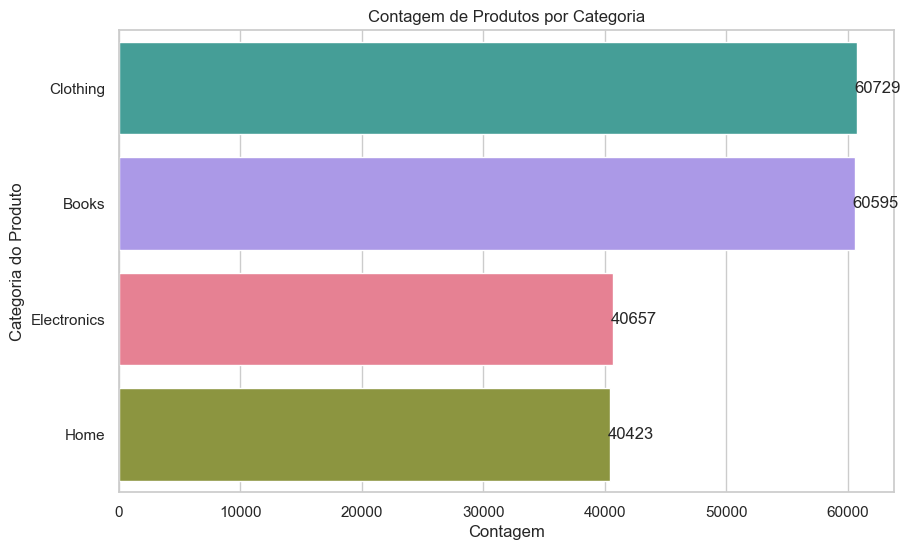

In [25]:
# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Plotando o gráfico de contagem para a coluna "Product Category"
plt.figure(figsize=(10, 6))
plt.title("Contagem de Produtos por Categoria")
grafico = sns.countplot(y="Product Category", data=dados_vendas, hue="Product Category", order=dados_vendas['Product Category'].value_counts().index, palette='husl', legend=False)
plt.xlabel("Contagem")
plt.ylabel("Categoria do Produto")

# Adicionando a Numeração de cada barra
for p in grafico.patches:
    grafico.annotate(format(p.get_width(), '.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha = 'center', va = 'center',
                     xytext = (15, 0),
                     textcoords = 'offset points')

plt.show()



### Temos acima uma contagem dos produtos separados por categoria para avaliarmos quais as categorias se saem melhores em termos de vendas.

É possível ver que a categoria de 'Clothing'(Roupas) é a mais vendida tendo 75052 vendas com uma pequena diferença da categoria 'Books'(Livros) que obteve o segundo lugar com 74912 vendas, Entretanto do segundo lugar para o terceiro a categoria 'Eletronics'(Eletrônicos) notamos uma diminuição de aproximadamente 33,01%.

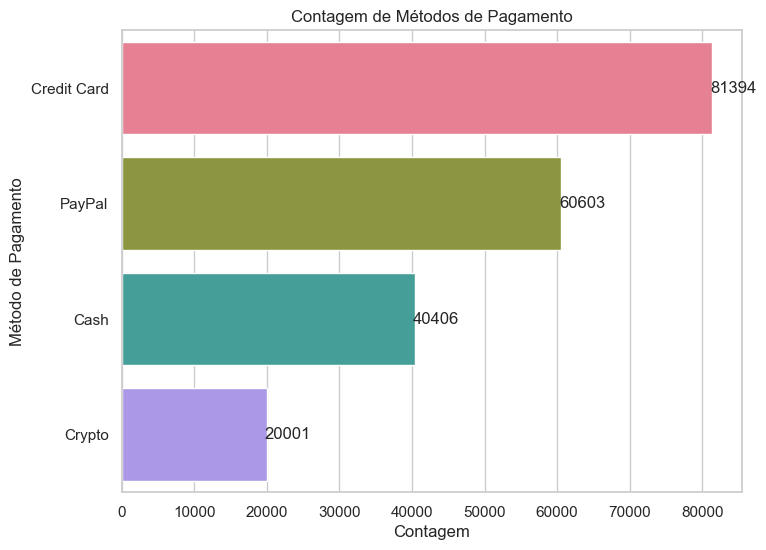

In [26]:
# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Plotando o gráfico de contagem para a coluna "Payment Method" 
plt.figure(figsize=(8, 6))
plt.title("Contagem de Métodos de Pagamento")
grafico = sns.countplot(y="Payment Method", data=dados_vendas, hue="Payment Method", palette='husl', legend=False)
plt.xlabel("Contagem")
plt.ylabel("Método de Pagamento")

# Adicionando a numeração em cada barra
for p in grafico.patches:
    grafico.annotate(format(p.get_width(), '.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center',
                     xytext=(15, 0),
                     textcoords='offset points')

plt.show()


### Agora como mostrado no gráfico acima avaliaremos as vendas separadas por métodos de pagamento

Na primeira posição vemos o 'credit_card'(cartão de crédito) com uma diferença de 25,53% em cima da categoria seguinte 'Paypal'(ferramenta que oferece as opções de envio e recebimento de pagamentos).

### Iremos agora fazer um paralelo entre as variáveis 'Payment Method' e 'Product Category'

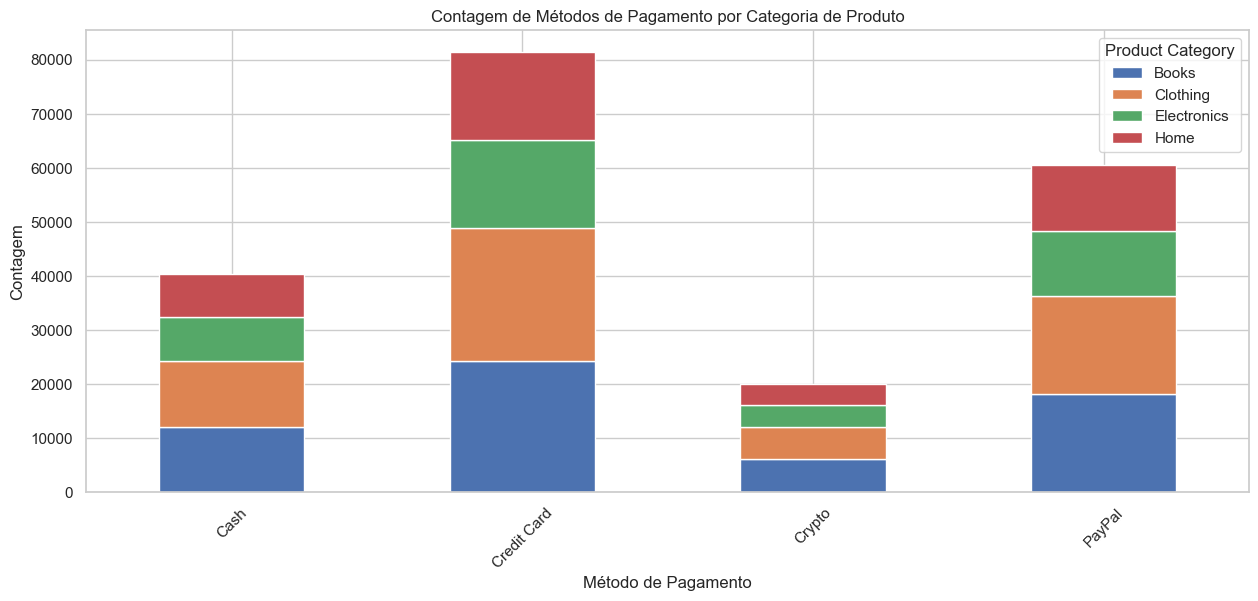

In [27]:
# Calculando a tabela cruzada entre 'Payment Method' e 'Product Category'
crosstab_result = pd.crosstab(df['Payment Method'], df['Product Category'])

# Plotando o gráfico de barras empilhadas
crosstab_result.plot(kind='bar', stacked=True, figsize=(15, 6))
plt.title('Contagem de Métodos de Pagamento por Categoria de Produto')
plt.xlabel('Método de Pagamento')
plt.ylabel('Contagem')
plt.xticks(rotation=45) 
plt.show()


Acima podemos ter uma visão bem clara que até mesmo separando por categorias o método de poagamento Credit Card é sempre dominante, possivelmente devido à conveniência e ao amplo uso de cartões de crédito. Crypto é o método menos preferido, sugerindo que a aceitação ou a adoção de criptomoedas ainda é baixa entre os clientes. PayPal é um método bastante popular, indicando uma confiança significativa dos consumidores neste método de pagamento. Cash tem uma presença menor, mas ainda significativa, especialmente para Books e Clothing

### Para entendimento ainda mais aprofundado iremos analisar a coluna 'Gender" para entender se há um gênero dominante nas compras.

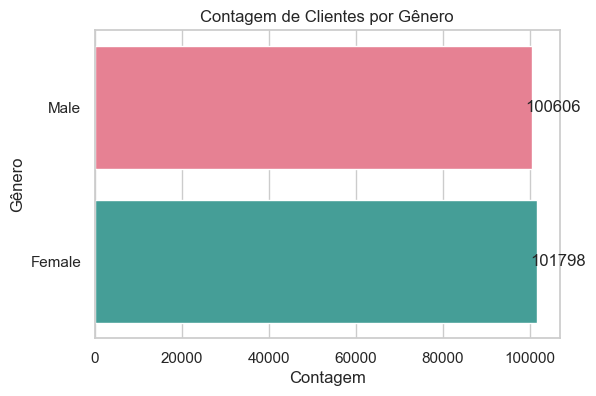

In [28]:
# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Plotando o gráfico de contagem para a coluna "Gender"
plt.figure(figsize=(6, 4))
plt.title("Contagem de Clientes por Gênero")
grafico = sns.countplot(y="Gender", data=dados_vendas, hue="Gender", palette='husl', legend=False)
plt.xlabel("Contagem")
plt.ylabel("Gênero")

# Adicionando a numeração em cada barra
for p in grafico.patches:
    grafico.annotate(format(p.get_width(), '.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha = 'center', va = 'center',
                     xytext = (15, 0),
                     textcoords = 'offset points')

plt.show()



Com os resultados do gráfico podemos perceber que a diferença entre o gênero não é muito impactante detendo somente 0,892% a mais para o gênero 'female"(feminino).


Faremos então um Paralelo entre as variáveis 'Gender' e 'Product Category' para verificar se há algum tipo de dominância em alguma das categorias.

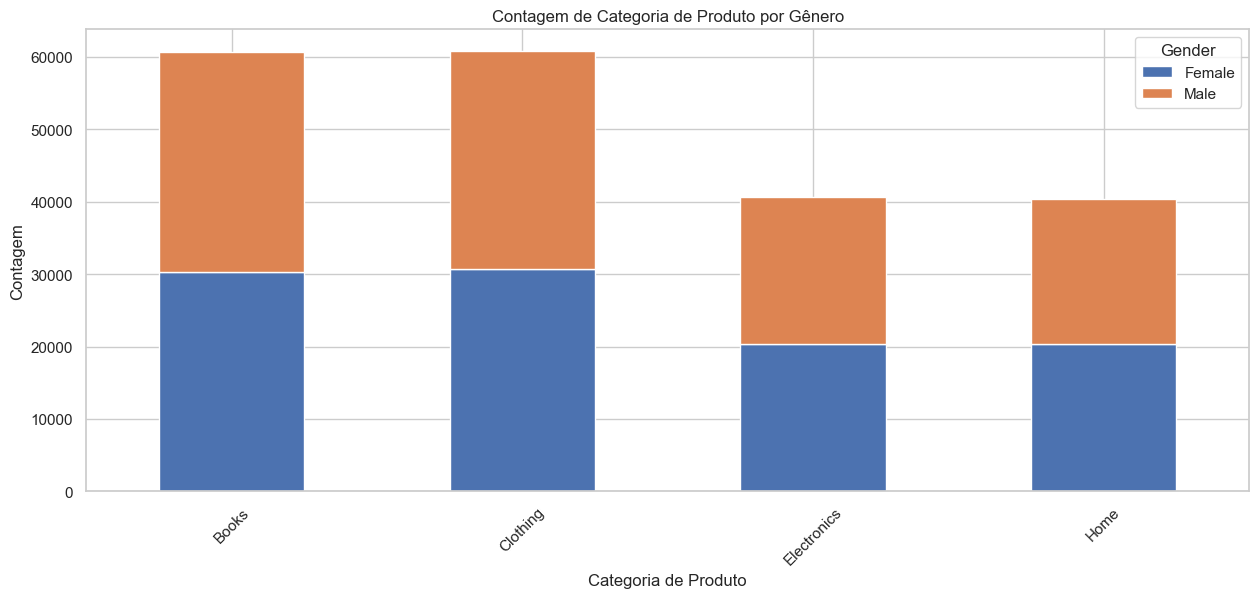

In [29]:
# Calculando a tabela cruzada entre 'Product Category' e 'Gender'
crosstab_result = pd.crosstab(df['Product Category'], df['Gender'])

# Plotando o gráfico de barras empilhadas
crosstab_result.plot(kind='bar', stacked=True, figsize=(15, 6))
plt.title('Contagem de Categoria de Produto por Gênero')
plt.xlabel('Categoria de Produto')
plt.ylabel('Contagem')
plt.xticks(rotation=45)  
plt.show()




De acordo com os resultados do Gráfico acima podemos chegar a conclusão de que não há uma preferência clara de gênero em relação às compras em diferentes categorias de produtos e Os resultados sugerem que os produtos oferecidos são igualmente atrativos para homens e mulheres.

### Vamos análisar a coluna 'Returns'

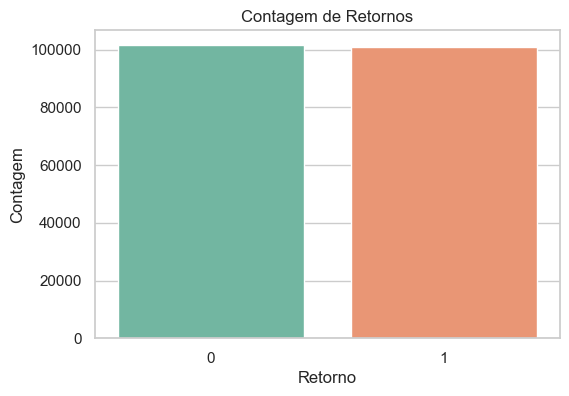

Contagem de Retornos:
Returns
0    101635
1    100769
Name: count, dtype: int64


In [30]:
# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Plotando o gráfico de contagem para a coluna "Returns"
plt.figure(figsize=(6, 4))
plt.title("Contagem de Retornos")
sns.countplot(x="Returns", hue="Returns", data=dados_vendas, palette="Set2", legend=False)
plt.xlabel("Retorno")
plt.ylabel("Contagem")
plt.show()

return_counts = dados_vendas['Returns'].value_counts()
print("Contagem de Retornos:")
print(return_counts)

Com Base nos resultados verificamos:

* Equilíbrio nas Compras com e sem Retorno:

A diferença entre o número de compras com e sem retorno é relativamente pequena, sugerindo um equilíbrio nas experiências de compra dos clientes e também O fato de que o número de compras sem retorno é ligeiramente maior do que com retorno pode indicar uma boa satisfação do cliente ou uma política de devolução eficaz.

* Potencial para Melhoria:

Embora o equilíbrio sugira uma experiência de compra geralmente positiva, a presença de retornos ainda indica áreas onde os clientes podem não estar totalmente satisfeitos, também é preciso analisar os motivos dos retornos e implementar medidas para melhorar a qualidade dos produtos, o processo de entrega ou o atendimento ao cliente pode ajudar a reduzir o número de devoluções e aprimorar a experiência geral do cliente.

* Monitoramento Contínuo:

É importante continuar monitorando e analisando os padrões de retorno ao longo do tempo para identificar tendências e ajustar estratégias conforme necessário, além de manter um equilíbrio saudável entre compras com e sem retorno é crucial para garantir a satisfação do cliente e o sucesso geral do negócio.



### Agora teremos um paralelo entre as colunas 'Returns' e 'Product Category'

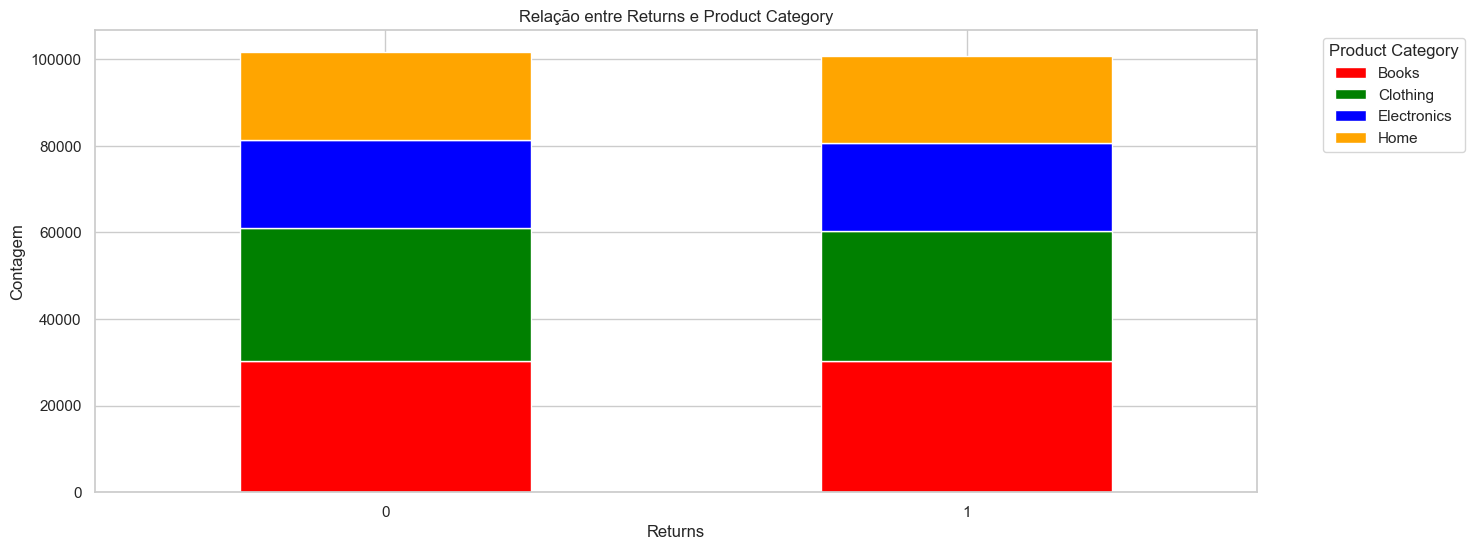

In [31]:
# Calculando a tabela cruzada entre 'Returns' e 'Product Category'
crosstab_result = pd.crosstab(df['Returns'], df['Product Category'])

# Plotando o gráfico de barras empilhadas
crosstab_result.plot(kind='bar', stacked=True, figsize=(15, 6), color=['red', 'green', 'blue', 'orange'])
plt.title('Relação entre Returns e Product Category')
plt.xlabel('Returns')
plt.ylabel('Contagem')
plt.xticks(rotation=0)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Com os resultados do gráfico acima é possível avaliar que não já diferenças significativas entre as categorias de produtos para explicar de uma melhor forma se há preferência por devolução de algo específico.

### Vamos análisar a coluna 'Churn'

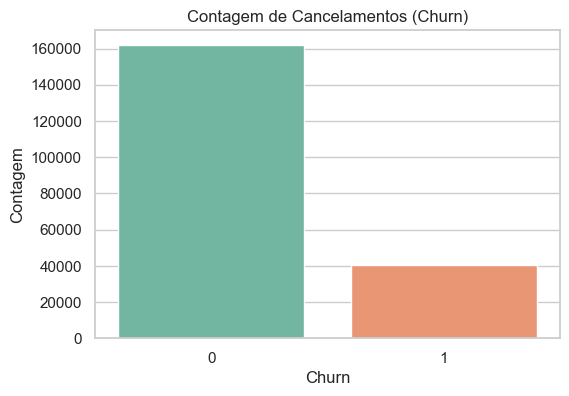

Contagem de Cancelamentos (Churn):
Churn
0    162040
1     40364
Name: count, dtype: int64


In [32]:
# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Plotando o gráfico de contagem para a coluna "Churn"
plt.figure(figsize=(6, 4))
plt.title("Contagem de Cancelamentos (Churn)")
sns.countplot(x="Churn", hue="Churn", data=dados_vendas, palette="Set2", legend=False)
plt.xlabel("Churn")
plt.ylabel("Contagem")
plt.show()

# Contagem dos valores na coluna "Churn"
churn_counts = dados_vendas['Churn'].value_counts()
print("Contagem de Cancelamentos (Churn):")
print(churn_counts)


Após plotarmos a categoria a variavel 'Churn' identificamos que a proporção de clientes que cancelaram em relação ao total é de aproximadamente 20%, o cancelamento pode representar um desafio significativo para a empresa, pois afeta diretamente a receita e a fidelidade do cliente é importante pensar em estratégias eficazes de retenção de clientes podem ser necessárias para reduzir o número de cancelamentos e aumentar a satisfação e a fidelidade do cliente.

### Agora um paralelo entre as colunas 'Churn' e 'Product Category'

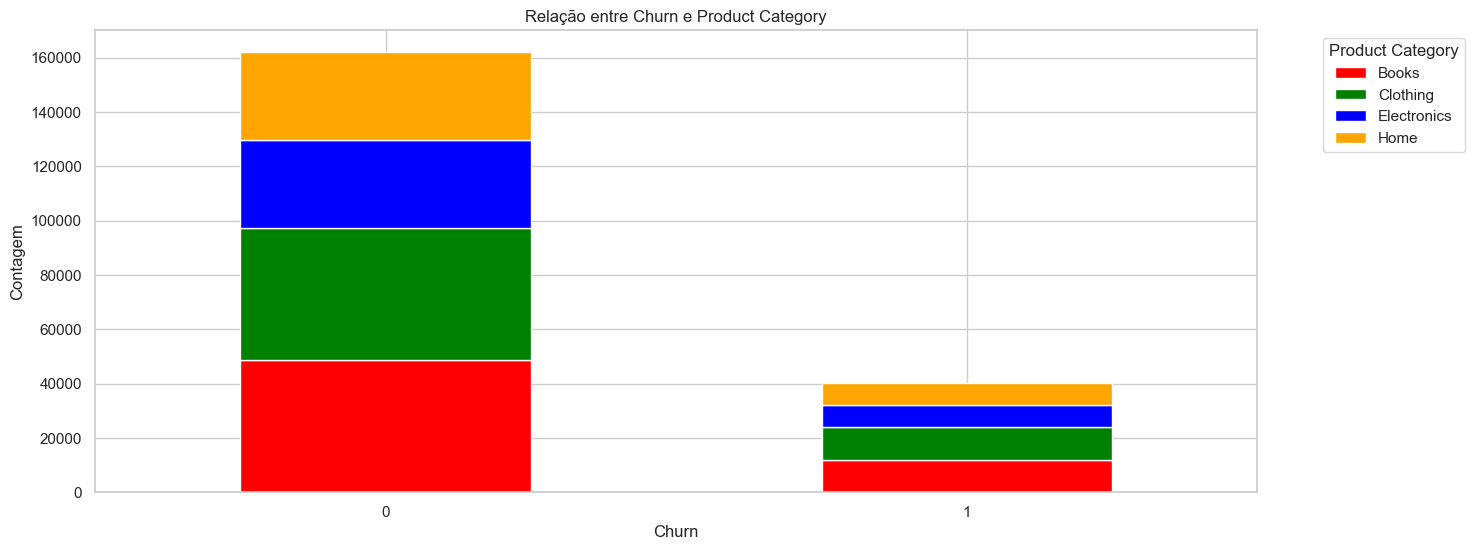

In [33]:
# Calculando a tabela cruzada entre 'Churn' e 'Product Category'
crosstab_result_churn = pd.crosstab(df['Churn'], df['Product Category'])

# Plotando o gráfico de barras empilhadas
crosstab_result_churn.plot(kind='bar', stacked=True, figsize=(15, 6), color=['red', 'green', 'blue', 'orange', 'purple'])
plt.title('Relação entre Churn e Product Category')
plt.xlabel('Churn')
plt.ylabel('Contagem')
plt.xticks(rotation=0)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Depois de fazer um paralelo entre a variavel 'Churn' e a variavel 'Product Category' é possivel indentificar que as categorias "Books" e "Clothing" têm o maior número de cancelamentos, seguidas por "Home" e "Electronics", além disso identificamos áreas para melhorias, seja na qualidade do produto, na experiência do cliente ou em estratégias de retenção específicas para cada categoria.

# Pré Processamento dos Dados

In [34]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df.head()

,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Age,Gender,Churn
0,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,0,37,Male,0
1,2022-03-05 12:56:35,Home,468,4,2739,PayPal,0,37,Male,0
2,2022-05-23 18:18:01,Home,288,2,3196,PayPal,0,37,Male,0
3,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,0,37,Male,0
4,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,0,49,Female,1


In [35]:
# Cria o encoder
lb = LabelEncoder()

# Convertendo 'Purchase Date' para formato de data
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])

# Aplica o encoder nas variáveis categóricas
df['Product Category'] = lb.fit_transform(df['Product Category'])
df['Gender'] = lb.fit_transform(df['Gender'])
df['Payment Method'] = lb.fit_transform(df['Payment Method'])

In [36]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df.head(20)

,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Age,Gender,Churn
0,2020-09-08 09:38:32,2,12,3,740,1,0,37,1,0
1,2022-03-05 12:56:35,3,468,4,2739,3,0,37,1,0
2,2022-05-23 18:18:01,3,288,2,3196,3,0,37,1,0
3,2020-11-12 13:13:29,1,196,1,3509,3,0,37,1,0
4,2020-11-27 17:55:11,3,449,1,3452,1,0,49,0,1
5,2023-03-07 14:17:42,3,250,4,575,3,1,49,0,1
6,2023-04-15 03:02:33,2,73,1,1896,1,0,49,0,1
7,2021-03-27 21:23:28,0,337,2,2937,0,0,49,0,1
8,2020-05-05 20:14:00,1,182,2,3363,3,1,49,0,1
9,2023-09-13 04:24:00,2,394,2,1993,1,0,19,1,0


In [37]:
# Shape
df.shape

(202404, 10)

In [38]:
# Verificando se a variável resposta está balanceada
target_count = df['Churn'].value_counts()
print(target_count)

Churn
0    162040
1     40364
Name: count, dtype: int64


In [39]:
# Verificando a variável resposta 
print(df['Churn'].head(10))


0    0
1    0
2    0
3    0
4    1
5    1
6    1
7    1
8    1
9    0
Name: Churn, dtype: int32


In [40]:
#Verificação de valores faltantes
print(df.isna().sum())

Purchase Date            0
Product Category         0
Product Price            0
Quantity                 0
Total Purchase Amount    0
Payment Method           0
Returns                  0
Age                      0
Gender                   0
Churn                    0
dtype: int64


In [41]:
# Shape
df.shape

(202404, 10)

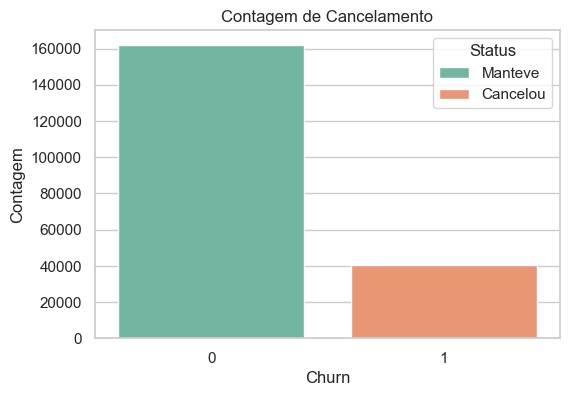

Contagem de Cancelamento:
Churn
0    162040
1     40364
Name: count, dtype: int64


In [42]:

# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Plotando o gráfico de contagem para a coluna "Churn"
plt.figure(figsize=(6, 4))
plt.title("Contagem de Cancelamento")
sns.countplot(x="Churn", hue="Churn", data=df, palette="Set2", dodge=False)
plt.xlabel("Churn")
plt.ylabel("Contagem")

# Adicionando a legenda 
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Manteve', 'Cancelou']
plt.legend(handles, labels, title="Status")

plt.show()

# Contagem de Cancelamento
return_counts = df['Churn'].value_counts()
print("Contagem de Cancelamento:")
print(return_counts)

Observando os resultados temos algumas avaliações  de Percentual 
* Clientes Retidos:Aproximadamente 80% dos clientes não cancelaram.
* Clientes Cancelados: Aproximadamente 20% dos clientes cancelaram.

Esses percentuais fornecem uma visão clara de que a maioria dos clientes está satisfeita ou, pelo menos, não cancelou o serviço, enquanto uma minoria significativa optou pelo cancelamento, o que pode ser um ponto de análise para entender e possivelmente reduzir o churn.

Agora faremos um tratamento na nossa variavel alvo para utilizarmos no modelo

In [43]:
# Seed
seed = 1000

# Verifica se há valores NaN na coluna 'Churn'
print("Valores NaN antes do tratamento:")
print(df['Churn'].isna().sum())

# Trata os valores NaN (removendo as linhas com NaN na coluna 'Churn')
df = df.dropna(subset=['Churn'])

# Verifica novamente para garantir que os valores NaN foram removidos
print("Valores NaN depois do tratamento:")
print(df['Churn'].isna().sum())

# Dividindo os dados em características (X) e alvo (y)
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])
df['Purchase Year'] = df['Purchase Date'].dt.year
df['Purchase Month'] = df['Purchase Date'].dt.month
df['Purchase Day'] = df['Purchase Date'].dt.day
df['Purchase Hour'] = df['Purchase Date'].dt.hour

# Removendo a coluna original de data e outras que não são necessárias
X = df.drop(['Churn', 'Purchase Date'], axis=1)
y = df['Churn']

# Seleciona apenas as colunas numéricas para X
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
X_numeric = X[numeric_features]

# Cria o pré-processador para padronizar os dados
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numeric_features)])

# Cria o pipeline com pré-processador e balanceador SMOTE
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('smote', SMOTE(random_state=seed))])

# Aplica o pipeline
X_res, y_res = pipeline.fit_resample(X_numeric, y)

print(f"Antes do balanceamento:\n{y.value_counts()}")
print(f"Depois do balanceamento:\n{y_res.value_counts()}")


Valores NaN antes do tratamento:
0
Valores NaN depois do tratamento:
0
Antes do balanceamento:
Churn
0    162040
1     40364
Name: count, dtype: int64
Depois do balanceamento:
Churn
0    162040
1    162040
Name: count, dtype: int64


In [44]:
# Shape dos dados originais
df.shape

(202404, 14)

In [45]:
df.head()

,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Age,Gender,Churn,Purchase Year,Purchase Month,Purchase Day,Purchase Hour
0,2020-09-08 09:38:32,2,12,3,740,1,0,37,1,0,2020,9,8,9
1,2022-03-05 12:56:35,3,468,4,2739,3,0,37,1,0,2022,3,5,12
2,2022-05-23 18:18:01,3,288,2,3196,3,0,37,1,0,2022,5,23,18
3,2020-11-12 13:13:29,1,196,1,3509,3,0,37,1,0,2020,11,12,13
4,2020-11-27 17:55:11,3,449,1,3452,1,0,49,0,1,2020,11,27,17


In [46]:
# Shape dos dados reamostrados
y_res.shape

(324080,)

In [47]:
# Ajustando X e y para utilizar apenas 1000 observações
X = X_res
y = y_res



In [48]:
# Divisão em Dados de Treino e Teste.
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Matriz De Confusão

Matriz de Confusão:
[[30841 17613]
 [ 7956  4312]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.79      0.64      0.71     48454
           1       0.20      0.35      0.25     12268

    accuracy                           0.58     60722
   macro avg       0.50      0.49      0.48     60722
weighted avg       0.67      0.58      0.62     60722

Tempo de treinamento: 3936.15 segundos
Tempo de previsão: 227.89 segundos


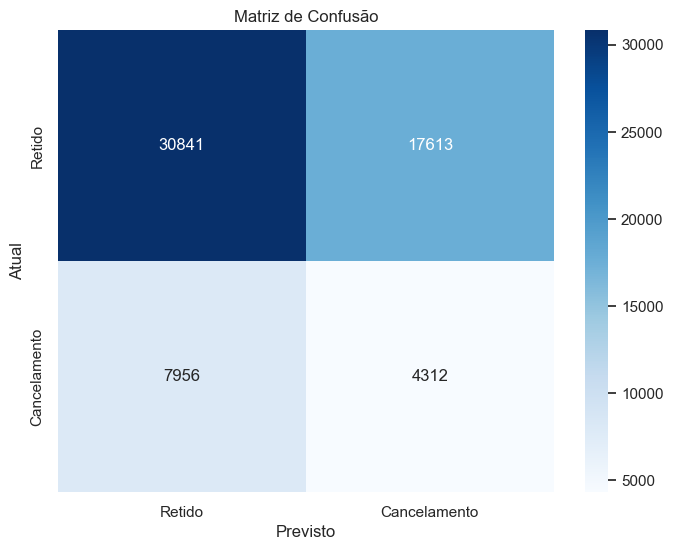

In [49]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

# Codificando variáveis categóricas se necessário
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criando um pipeline com oversampling SMOTE e SVM
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', random_state=42))
])

# Medindo o tempo de treinamento
start_train = time.time()
pipeline.fit(X_train, y_train)
end_train = time.time()

# Medindo o tempo de previsão
start_pred = time.time()
y_pred = pipeline.predict(X_test)
end_pred = time.time()

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

# Gerando um relatório de classificação para mais métricas
class_report = classification_report(y_test, y_pred)
print("Relatório de Classificação:")
print(class_report)

# Tempo de execução
train_time = end_train - start_train
pred_time = end_pred - start_pred
print(f"Tempo de treinamento: {train_time:.2f} segundos")
print(f"Tempo de previsão: {pred_time:.2f} segundos")

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Retido', 'Cancelamento'], yticklabels=['Retido', 'Cancelamento'])
plt.xlabel('Previsto')
plt.ylabel('Atual')
plt.title('Matriz de Confusão')

# Salvando a imagem do plot da matriz de confusão
plt.savefig('confusion_matrix.png')

plt.show()


# Modelo SVM

### Modelo Base com Kernel Linear

In [49]:
# Cria o modelo
modelo_v1 = svm.SVC(kernel = 'linear')

In [50]:
# Treinamento
start = time.time()
modelo_v1.fit(X_treino, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

Tempo de Treinamento do Modelo: 1035.7867698669434


In [51]:
# Previsões
previsoes_v1 = modelo_v1.predict(X_teste)

In [52]:
# Dicionário de métricas e metadados
SVM_dict_v1 = {'Modelo':'SVM',
               'Versão':'1',
               'Kernel':'Linear',
               'Precision':precision_score(previsoes_v1, y_teste),
               'Recall':recall_score(previsoes_v1, y_teste),
               'F1 Score':f1_score(previsoes_v1, y_teste),
               'Acurácia':accuracy_score(previsoes_v1, y_teste),
               'AUC':roc_auc_score(y_teste, previsoes_v1)}

In [53]:
# Print
print("Métricas em Teste:\n")
SVM_dict_v1

Métricas em Teste:



{'Modelo': 'SVM',
 'Versão': '1',
 'Kernel': 'Linear',
 'Precision': 0.5166105754341048,
 'Recall': 0.4999500469558615,
 'F1 Score': 0.5081437855402112,
 'Acurácia': 0.5017896815601086,
 'AUC': 0.5018440551126786}

### Modelo com Kernel Linear e Dados Padronizados (Scaled)

In [54]:
# Agora sim, a forma ideal de aplicar a padronização em treino e teste
# Padronização
sc = StandardScaler()
X_treino_scaled = sc.fit_transform(X_treino)
X_teste_scaled = sc.transform(X_teste)

In [55]:
X_treino_scaled

array([[-1.20960761e+00,  9.43104033e-04,  2.76112514e-01,
         3.97349295e-01],
       [-1.43564840e+00, -1.41126025e+00, -1.41534836e+00,
         5.27448364e-01],
       [-1.15963865e+00,  1.41314646e+00,  6.91644897e-01,
        -6.92020667e-03],
       ...,
       [-9.27056609e-01,  7.07044782e-01, -1.33063644e+00,
        -5.79974480e-02],
       [-2.63061764e-01,  9.43104033e-04, -1.58268911e+00,
        -1.35898814e+00],
       [ 3.86805530e-01,  7.07044782e-01, -1.62296199e+00,
         9.82795106e-01]])

In [56]:
X_teste_scaled

array([[-1.85360240e-01,  9.43104033e-04,  1.13711887e+00,
         1.37309231e+00],
       [-4.18464813e-01,  9.43104033e-04,  1.28571190e+00,
         2.67250225e-01],
       [ 8.24759577e-01,  1.41314646e+00,  5.83019618e-01,
        -1.88096517e-01],
       ...,
       [ 1.20620342e+00, -1.41126025e+00,  7.30223930e-01,
        -3.83245121e-01],
       [-9.97694358e-01, -7.05158574e-01,  1.14683991e+00,
        -1.68423581e+00],
       [-1.33675556e+00, -7.05158574e-01, -1.52783467e+00,
        -1.35898814e+00]])

In [57]:
# Cria o modelo
modelo_v2 = svm.SVC(kernel = 'linear')

In [58]:
# Treinamento
start = time.time()
modelo_v2.fit(X_treino_scaled, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

Tempo de Treinamento do Modelo: 1019.5906615257263


In [59]:
# Previsões
previsoes_v2 = modelo_v2.predict(X_teste_scaled)

In [60]:
# Dicionário de métricas e metadados
SVM_dict_v2 = {'Modelo':'SVM',
               'Versão':'2',
               'Kernel':'Linear com Dados Padronizados',
               'Precision':precision_score(previsoes_v2, y_teste),
               'Recall':recall_score(previsoes_v2, y_teste),
               'F1 Score':f1_score(previsoes_v2, y_teste),
               'Acurácia':accuracy_score(previsoes_v2, y_teste),
               'AUC':roc_auc_score(y_teste, previsoes_v2)}

In [61]:
# Print
print("Métricas em Teste:\n")
SVM_dict_v2

Métricas em Teste:



{'Modelo': 'SVM',
 'Versão': '2',
 'Kernel': 'Linear com Dados Padronizados',
 'Precision': 0.5166518695930461,
 'Recall': 0.4999400623351714,
 'F1 Score': 0.5081586028329187,
 'Acurácia': 0.5017793960339011,
 'AUC': 0.5018339588173465}

### Otimização de Hiperparâmetros com RandomizedSearch e Kernel RBF

In [62]:
# Definir o modelo SVM com kernel RBF
modelo_v3 = svm.SVC(kernel='rbf')

# Valores para o grid inicial
C_range = np.array([50., 100., 200.])
gamma_range = np.array([0.3*0.001, 0.001, 3*0.001])

# Grid de hiperparâmetros
svm_param_grid = dict(gamma=gamma_range, C=C_range)

# Usando RandomizedSearch
start = time.time()
modelo_v3_random_search_rbf = RandomizedSearchCV(modelo_v3, param_distributions=svm_param_grid, n_iter=5, cv=3, n_jobs=-1)

# Treinamento
modelo_v3_random_search_rbf.fit(X_treino_scaled, y_treino)
end = time.time()

# Resultados
print('Tempo de Treinamento do Modelo com Randomized Search:', end - start)
print(f"Acurácia em Treinamento: {modelo_v3_random_search_rbf.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {modelo_v3_random_search_rbf.best_params_}")

Tempo de Treinamento do Modelo com Randomized Search: 5943.00283908844
Acurácia em Treinamento: 50.13%

Hiperparâmetros Ideais: {'gamma': 0.0003, 'C': 200.0}


In [63]:
# Previsões
previsoes_v3 = modelo_v3_random_search_rbf.predict(X_teste_scaled)

In [64]:
# Dicionário de métricas e metadados
SVM_dict_v3 = {'Modelo':'SVM',
               'Versão':'3',
               'Kernel':'RBF com Dados Padronizados',
               'Precision':precision_score(previsoes_v3, y_teste),
               'Recall':recall_score(previsoes_v3, y_teste),
               'F1 Score':f1_score(previsoes_v3, y_teste),
               'Acurácia':accuracy_score(previsoes_v3, y_teste),
               'AUC':roc_auc_score(y_teste, previsoes_v3)}

In [65]:
# Print
print("Métricas em Teste:\n")
SVM_dict_v3

Métricas em Teste:



{'Modelo': 'SVM',
 'Versão': '3',
 'Kernel': 'RBF com Dados Padronizados',
 'Precision': 0.535977535977536,
 'Recall': 0.5003372973806449,
 'F1 Score': 0.5175445591929503,
 'Acurácia': 0.5022011026084094,
 'AUC': 0.502325018526777}

### Otimização de Hiperparâmetros com RandomizedSearch e Kernel Polinomial

In [70]:
# Cria o modelo
modelo_v4 = svm.SVC(kernel='poly')

# Valores para o grid
r_range = np.array([0.5, 1])
gamma_range = np.array([0.001, 0.01])
d_range = np.array([2, 3, 4])

# Grid de hiperparâmetros
param_grid_poly = dict(gamma=gamma_range, degree=d_range, coef0=r_range)

# Randomized Search
start = time.time()
modelo_v4_random_search_poly = RandomizedSearchCV(modelo_v4, param_distributions=param_grid_poly, n_iter=3, cv=3, n_jobs=-1)

# Treinamento
modelo_v4_random_search_poly.fit(X_treino_scaled, y_treino)
end = time.time()

# Resultados
print('Tempo de Treinamento do Modelo com Randomized Search:', end - start)
print(f"Acurácia em Treinamento: {modelo_v4_random_search_poly.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {modelo_v4_random_search_poly.best_params_}")


Tempo de Treinamento do Modelo com Randomized Search: 2231.1622326374054
Acurácia em Treinamento: 50.17%

Hiperparâmetros Ideais: {'gamma': 0.001, 'degree': 3, 'coef0': 0.5}


In [73]:
# Previsões
previsoes_v4 = modelo_v4_random_search_poly.predict(X_teste_scaled)

In [74]:
# Dicionário de métricas e metadados
SVM_dict_v4 = {'Modelo':'SVM',
               'Versão':'4',
               'Kernel':'Polinomial com Dados Padronizados',
               'Precision':precision_score(previsoes_v4, y_teste),
               'Recall':recall_score(previsoes_v4, y_teste),
               'F1 Score':f1_score(previsoes_v4, y_teste),
               'Acurácia':accuracy_score(previsoes_v4, y_teste),
               'AUC':roc_auc_score(y_teste, previsoes_v4)}

In [75]:
# Print
print("Métricas em Teste:\n")
SVM_dict_v4

Métricas em Teste:



{'Modelo': 'SVM',
 'Versão': '4',
 'Kernel': 'Polinomial com Dados Padronizados',
 'Precision': 0.5460120166002519,
 'Recall': 0.5009566386936672,
 'F1 Score': 0.5225148683092609,
 'Acurácia': 0.5028799473381058,
 'AUC': 0.5030381863657528}

In [76]:
# Concatena todos os dicionários em um dataframe do Pandas
resumo = pd.DataFrame({'SVM_Modelo_1':pd.Series(SVM_dict_v1),
                       'SVM_Modelo_2':pd.Series(SVM_dict_v2),
                       'SVM_Modelo_3':pd.Series(SVM_dict_v3),
                       'SVM_Modelo_4':pd.Series(SVM_dict_v4)})

In [77]:
# Print
resumo

,SVM_Modelo_1,SVM_Modelo_2,SVM_Modelo_3,SVM_Modelo_4
Modelo,SVM,SVM,SVM,SVM
Versão,1,2,3,4
Kernel,Linear,Linear com Dados Padronizados,RBF com Dados Padronizados,Polinomial com Dados Padronizados
Precision,0.516611,0.516652,0.535978,0.546012
Recall,0.49995,0.49994,0.500337,0.500957
F1 Score,0.508144,0.508159,0.517545,0.522515
Acurácia,0.50179,0.501779,0.502201,0.50288
AUC,0.501844,0.501834,0.502325,0.503038


Para melhor visualização iremos avaliar os resultados em gráficos

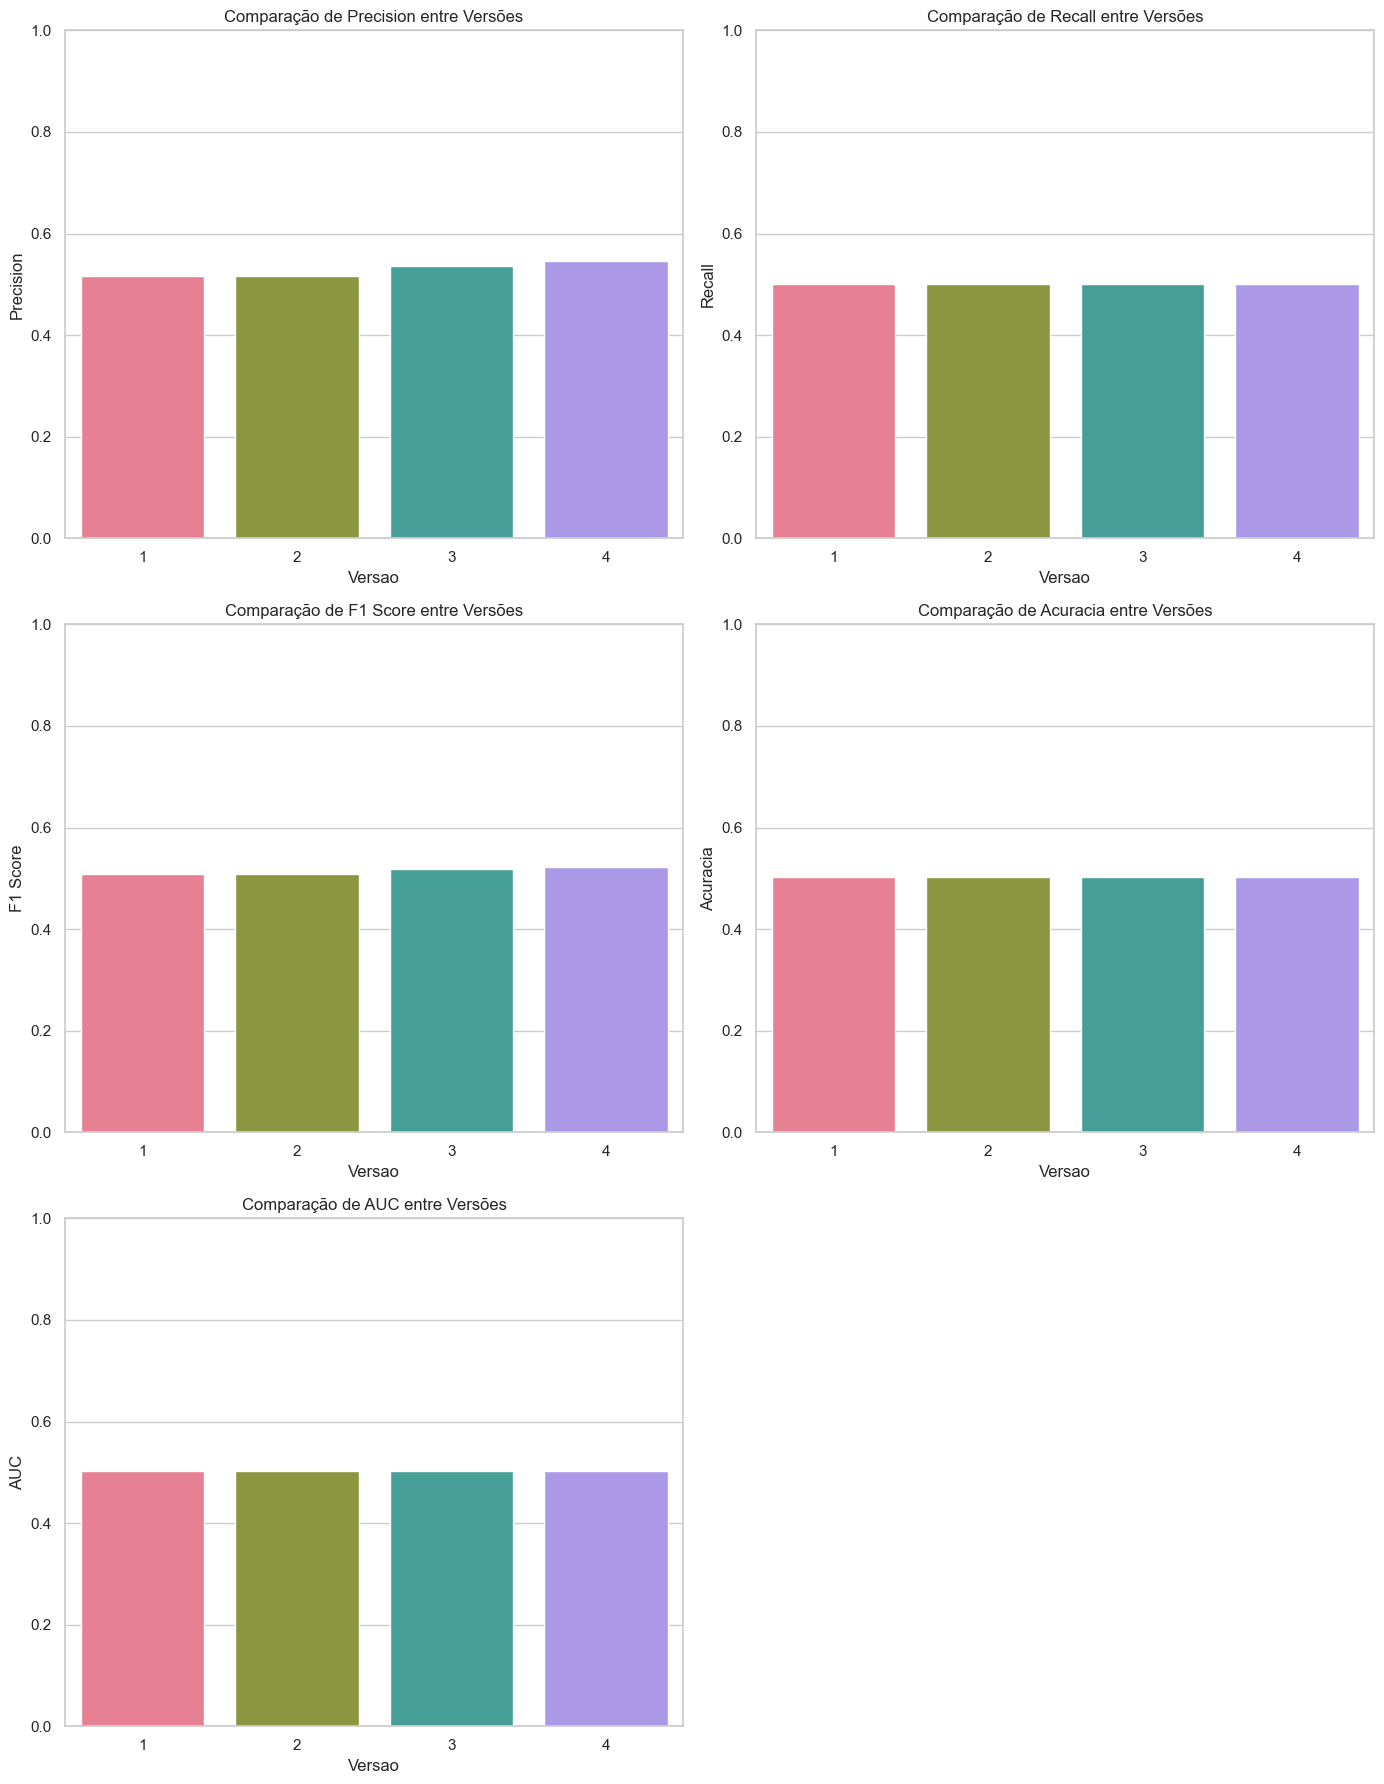

In [106]:
# Ignorando avisos futuros
warnings.filterwarnings('ignore', category=FutureWarning)

# Dados das métricas
data = {
    'Modelo': ['SVM', 'SVM', 'SVM', 'SVM'],
    'Versao': ['1', '2', '3', '4'],
    'Kernel': ['Linear', 'Linear com Dados Padronizados', 'RBF com Dados Padronizados', 'Polinomial com Dados Padronizados'],
    'Precision': [0.516611, 0.516652, 0.535978, 0.546012],
    'Recall': [0.49995, 0.49994, 0.500337, 0.500957],
    'F1 Score': [0.508144, 0.508159, 0.517545, 0.522515],
    'Acuracia': [0.50179, 0.501779, 0.502201, 0.50288],
    'AUC': [0.501844, 0.501834, 0.502325, 0.503038]
}

# Convertendo os dados em um DataFrame
df_SVM = pd.DataFrame(data)

# Configurando o estilo do seaborn
sns.set(style="whitegrid")

# Definindo a paleta de cores
palette = sns.color_palette("husl", len(df_SVM['Versao'].unique()))

# Criando gráficos de barras para cada métrica
metrics = ['Precision', 'Recall', 'F1 Score', 'Acuracia', 'AUC']
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    sns.barplot(x='Versao', y=metric, hue='Versao', data=df_SVM, ax=ax, palette=palette, dodge=False, legend=False)
    ax.set_title(f'Comparação de {metric} entre Versões')
    ax.set_ylim(0, 1)  
    
# Remover o gráfico vazio
fig.delaxes(axes[2, 1])

# Ajustar layout
plt.tight_layout()

# Mostrar os gráficos
plt.show()


Observações

Precision: A precisão do modelo aumenta gradualmente com o aumento da versão do modelo SVM. O modelo SVM com kernel polinomial e dados padronizados (Versão 4) apresenta a maior precisão, com um valor de 0.546.

Recall: O recall se mantém relativamente estável ao longo das diferentes versões do modelo SVM, com variações muito pequenas entre elas. Todos os modelos têm valores de recall próximos de 0.5, indicando uma proporção semelhante de verdadeiros positivos detectados em relação ao total de verdadeiros positivos.

F1 Score: O F1 Score, que é uma medida que combina precisão e recall, também aumenta gradualmente com o aumento da versão do modelo SVM. Assim como na precisão, o modelo SVM com kernel polinomial e dados padronizados (Versão 4) alcança o maior F1 Score, com um valor de 0.523.

Acurácia: A acurácia se mantém relativamente estável ao longo das diferentes versões do modelo SVM, com variações muito pequenas entre elas. Todos os modelos têm valores de acurácia próximos de 0.5, o que sugere uma capacidade semelhante de classificação correta das instâncias em relação ao total de instâncias.

AUC: A área sob a curva ROC (AUC) também aumenta gradualmente com o aumento da versão do modelo SVM. O modelo SVM com kernel polinomial e dados padronizados (Versão 4) apresenta a maior AUC, com um valor de 0.503.

Em resumo, podemos observar melhorias graduais nas métricas de desempenho à medida que a versão do modelo SVM aumenta, com o modelo SVM com kernel polinomial e dados padronizados apresentando o melhor desempenho geral. No entanto, as melhorias são bastante sutis, especialmente em métricas como recall e acurácia.

# Modelo XgBoost

Iremos refazer algumas partes das definições para que não haja conflito entre os modelos

In [49]:
# Shape dos dados originais
df.shape

(202404, 14)

In [50]:
# Seed
seed = 1000

# Verifica se há valores NaN na coluna 'Churn'
print("Valores NaN antes do tratamento:")
print(df['Churn'].isna().sum())

# Trata os valores NaN (removendo as linhas com NaN na coluna 'Churn')
df = df.dropna(subset=['Churn'])

# Verifica novamente para garantir que os valores NaN foram removidos
print("Valores NaN depois do tratamento:")
print(df['Churn'].isna().sum())

# Dividindo os dados em características (X) e alvo (y)
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])
df['Purchase Year'] = df['Purchase Date'].dt.year
df['Purchase Month'] = df['Purchase Date'].dt.month
df['Purchase Day'] = df['Purchase Date'].dt.day
df['Purchase Hour'] = df['Purchase Date'].dt.hour

# Removendo a coluna original de data e outras que não são necessárias
X = df.drop(['Churn', 'Purchase Date'], axis=1)
y = df['Churn']

# Seleciona apenas as colunas numéricas para X
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
X_numeric = X[numeric_features]

# Cria o pré-processador para padronizar os dados
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numeric_features)])

# Cria o pipeline com pré-processador e balanceador SMOTE
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('smote', SMOTE(random_state=seed))])

# Aplica o pipeline
X_res, y_res = pipeline.fit_resample(X_numeric, y)

print(f"Antes do balanceamento:\n{y.value_counts()}")
print(f"Depois do balanceamento:\n{y_res.value_counts()}")


Valores NaN antes do tratamento:
0
Valores NaN depois do tratamento:
0
Antes do balanceamento:
Churn
0    162040
1     40364
Name: count, dtype: int64
Depois do balanceamento:
Churn
0    162040
1    162040
Name: count, dtype: int64


In [51]:
df.head()

,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Age,Gender,Churn,Purchase Year,Purchase Month,Purchase Day,Purchase Hour
0,2020-09-08 09:38:32,2,12,3,740,1,0,37,1,0,2020,9,8,9
1,2022-03-05 12:56:35,3,468,4,2739,3,0,37,1,0,2022,3,5,12
2,2022-05-23 18:18:01,3,288,2,3196,3,0,37,1,0,2022,5,23,18
3,2020-11-12 13:13:29,1,196,1,3509,3,0,37,1,0,2020,11,12,13
4,2020-11-27 17:55:11,3,449,1,3452,1,0,49,0,1,2020,11,27,17


In [52]:
# Shape dos dados reamostrados
y_res.shape

(324080,)

In [53]:
# Ajustando X e y para utilizar apenas 1000 observações
X = X_res
y = y_res



In [54]:
# Divisão em Dados de Treino e Teste.
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3, random_state = 42)

Modelo Base

In [70]:
# Cria o modelo
modelo_v5 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [71]:
# Treinamento
start = time.time()
modelo_v5.fit(X_treino, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

Tempo de Treinamento do Modelo: 0.3755767345428467


In [72]:
# Previsões
previsoes_v5 = modelo_v5.predict(X_teste)

In [74]:
# Dicionário de métricas e metadados
XGBOOST_dict_v5 = {
    'Modelo': 'XGBOOST',
    'Versão': '5',
    'Precision': precision_score(y_teste, previsoes_v5),
    'Recall': recall_score(y_teste, previsoes_v5),
    'F1 Score': f1_score(y_teste, previsoes_v5),
    'Acurácia': accuracy_score(y_teste, previsoes_v5),
    'AUC': roc_auc_score(y_teste, previsoes_v5)
}
# Print
print("Métricas em Teste:\n")
XGBOOST_dict_v5

Métricas em Teste:



{'Modelo': 'XGBOOST',
 'Versão': '5',
 'Precision': 0.8190911336132378,
 'Recall': 0.41085623438564617,
 'F1 Score': 0.5472245520920703,
 'Acurácia': 0.6613079075125483,
 'AUC': 0.6603890731068236}

Modelo Base com dados Padronizados

In [75]:
# Padronização
sc = StandardScaler()
X_treino_scaled = sc.fit_transform(X_treino)
X_teste_scaled = sc.transform(X_teste)

In [76]:
X_treino_scaled

array([[-1.20960761e+00,  9.43104033e-04,  2.76112514e-01,
         3.97349295e-01],
       [-1.43564840e+00, -1.41126025e+00, -1.41534836e+00,
         5.27448364e-01],
       [-1.15963865e+00,  1.41314646e+00,  6.91644897e-01,
        -6.92020667e-03],
       ...,
       [-9.27056609e-01,  7.07044782e-01, -1.33063644e+00,
        -5.79974480e-02],
       [-2.63061764e-01,  9.43104033e-04, -1.58268911e+00,
        -1.35898814e+00],
       [ 3.86805530e-01,  7.07044782e-01, -1.62296199e+00,
         9.82795106e-01]])

In [77]:
X_teste_scaled

array([[-1.85360240e-01,  9.43104033e-04,  1.13711887e+00,
         1.37309231e+00],
       [-4.18464813e-01,  9.43104033e-04,  1.28571190e+00,
         2.67250225e-01],
       [ 8.24759577e-01,  1.41314646e+00,  5.83019618e-01,
        -1.88096517e-01],
       ...,
       [ 1.20620342e+00, -1.41126025e+00,  7.30223930e-01,
        -3.83245121e-01],
       [-9.97694358e-01, -7.05158574e-01,  1.14683991e+00,
        -1.68423581e+00],
       [-1.33675556e+00, -7.05158574e-01, -1.52783467e+00,
        -1.35898814e+00]])

In [78]:
# Cria o modelo
modelo_v6 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [79]:
# Treinamento
start = time.time()
modelo_v6.fit(X_treino_scaled, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

Tempo de Treinamento do Modelo: 0.5597107410430908


In [81]:
# Previsões
previsoes_v6 = modelo_v6.predict(X_teste_scaled)

In [83]:
# Dicionário de métricas e metadados
XGBOOST_dict_v6 = {
    'Modelo': 'XGBOOST',
    'Versão': '6',
    'Precision': precision_score(y_teste, previsoes_v6),
    'Recall': recall_score(y_teste, previsoes_v6),
    'F1 Score': f1_score(y_teste, previsoes_v6),
    'Acurácia': accuracy_score(y_teste, previsoes_v6),
    'AUC': roc_auc_score(y_teste, previsoes_v6)
}
# Print
print("Métricas em Teste:\n")
XGBOOST_dict_v6

Métricas em Teste:



{'Modelo': 'XGBOOST',
 'Versão': '6',
 'Precision': 0.8190911336132378,
 'Recall': 0.41085623438564617,
 'F1 Score': 0.5472245520920703,
 'Acurácia': 0.6613079075125483,
 'AUC': 0.6603890731068236}

Otimização de Hiperparâmetros com GridSearch

In [85]:
# Cria o modelo
modelo_v7 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Valores para o grid
learning_rate_range = np.array([0.01, 0.1, 0.2])
max_depth_range = np.array([3, 4, 5])
n_estimators_range = np.array([50, 100, 200])
subsample_range = np.array([0.8, 1.0])
colsample_bytree_range = np.array([0.8, 1.0])

# Grid de hiperparâmetros
param_grid_xgb = {
    'learning_rate': learning_rate_range,
    'max_depth': max_depth_range,
    'n_estimators': n_estimators_range,
    'subsample': subsample_range,
    'colsample_bytree': colsample_bytree_range
}

# Grid Search
start = time.time()
modelo_v7_grid_search_xgb = GridSearchCV(
    modelo_v7, param_grid=param_grid_xgb, cv=3, n_jobs=-1
)

# Treinamento
modelo_v7_grid_search_xgb.fit(X_treino_scaled, y_treino)
end = time.time()

# Resultados
print('Tempo de Treinamento do Modelo com Grid Search:', end - start)
print(f"Acurácia em Treinamento: {modelo_v7_grid_search_xgb.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {modelo_v7_grid_search_xgb.best_params_}")

Tempo de Treinamento do Modelo com Grid Search: 77.84484696388245
Acurácia em Treinamento: 66.34%

Hiperparâmetros Ideais: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [86]:
# Previsões
previsoes_v7 = modelo_v7_grid_search_xgb.predict(X_teste_scaled)

In [87]:
# Dicionário de métricas e metadados
XGBOOST_dict_v7 = {
    'Modelo': 'XGBOOST',
    'Versão': '7',
    'Precision': precision_score(y_teste, previsoes_v7),
    'Recall': recall_score(y_teste, previsoes_v7),
    'F1 Score': f1_score(y_teste, previsoes_v7),
    'Acurácia': accuracy_score(y_teste, previsoes_v7),
    'AUC': roc_auc_score(y_teste, previsoes_v7)
}

# Print
print("Métricas em Teste:\n")
XGBOOST_dict_v7

Métricas em Teste:



{'Modelo': 'XGBOOST',
 'Versão': '7',
 'Precision': 0.8386663683150593,
 'Recall': 0.3869262692792105,
 'F1 Score': 0.5295430783576818,
 'Acurácia': 0.6575125483419731,
 'AUC': 0.6565198459183247}

Otimização com o GridSearch com os melhores Hiperparametros

In [88]:
# Cria o modelo com os hiperparâmetros ideais
modelo_v8 = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    colsample_bytree=1.0,
    learning_rate=0.2,
    max_depth=5,
    n_estimators=200,
    subsample=0.8
)

# Treinamento
start = time.time()
modelo_v8.fit(X_treino_scaled, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

Tempo de Treinamento do Modelo: 1.0020992755889893


In [89]:
# Previsões
previsoes_v8 = modelo_v8.predict(X_teste_scaled)

In [90]:
# Dicionário de métricas e metadados
XGBOOST_dict_v8 = {
    'Modelo': 'XGBOOST',
    'Versão': '8',
    'Precision': precision_score(y_teste, previsoes_v8),
    'Recall': recall_score(y_teste, previsoes_v8),
    'F1 Score': f1_score(y_teste, previsoes_v8),
    'Acurácia': accuracy_score(y_teste, previsoes_v8),
    'AUC': roc_auc_score(y_teste, previsoes_v8)
}

# Print
print("Métricas em Teste:\n")
XGBOOST_dict_v8

Métricas em Teste:



{'Modelo': 'XGBOOST',
 'Versão': '8',
 'Precision': 0.8386663683150593,
 'Recall': 0.3869262692792105,
 'F1 Score': 0.5295430783576818,
 'Acurácia': 0.6575125483419731,
 'AUC': 0.6565198459183247}

In [91]:
# Concatena todos os dicionários em um dataframe do Pandas
resumo = pd.DataFrame({'XGBOOST_Modelo_5':pd.Series(XGBOOST_dict_v5),
                       'XGBOOST_Modelo_6':pd.Series(XGBOOST_dict_v6),
                       'XGBOOST_Modelo_7':pd.Series(XGBOOST_dict_v7),
                       'XGBOOST_Modelo_8':pd.Series(XGBOOST_dict_v8)})

In [92]:
# Print
resumo

,XGBOOST_Modelo_5,XGBOOST_Modelo_6,XGBOOST_Modelo_7,XGBOOST_Modelo_8
Modelo,XGBOOST,XGBOOST,XGBOOST,XGBOOST
Versão,5,6,7,8
Precision,0.819091,0.819091,0.838666,0.838666
Recall,0.410856,0.410856,0.386926,0.386926
F1 Score,0.547225,0.547225,0.529543,0.529543
Acurácia,0.661308,0.661308,0.657513,0.657513
AUC,0.660389,0.660389,0.65652,0.65652


Visualização em Gráfico para um melhor entendimento

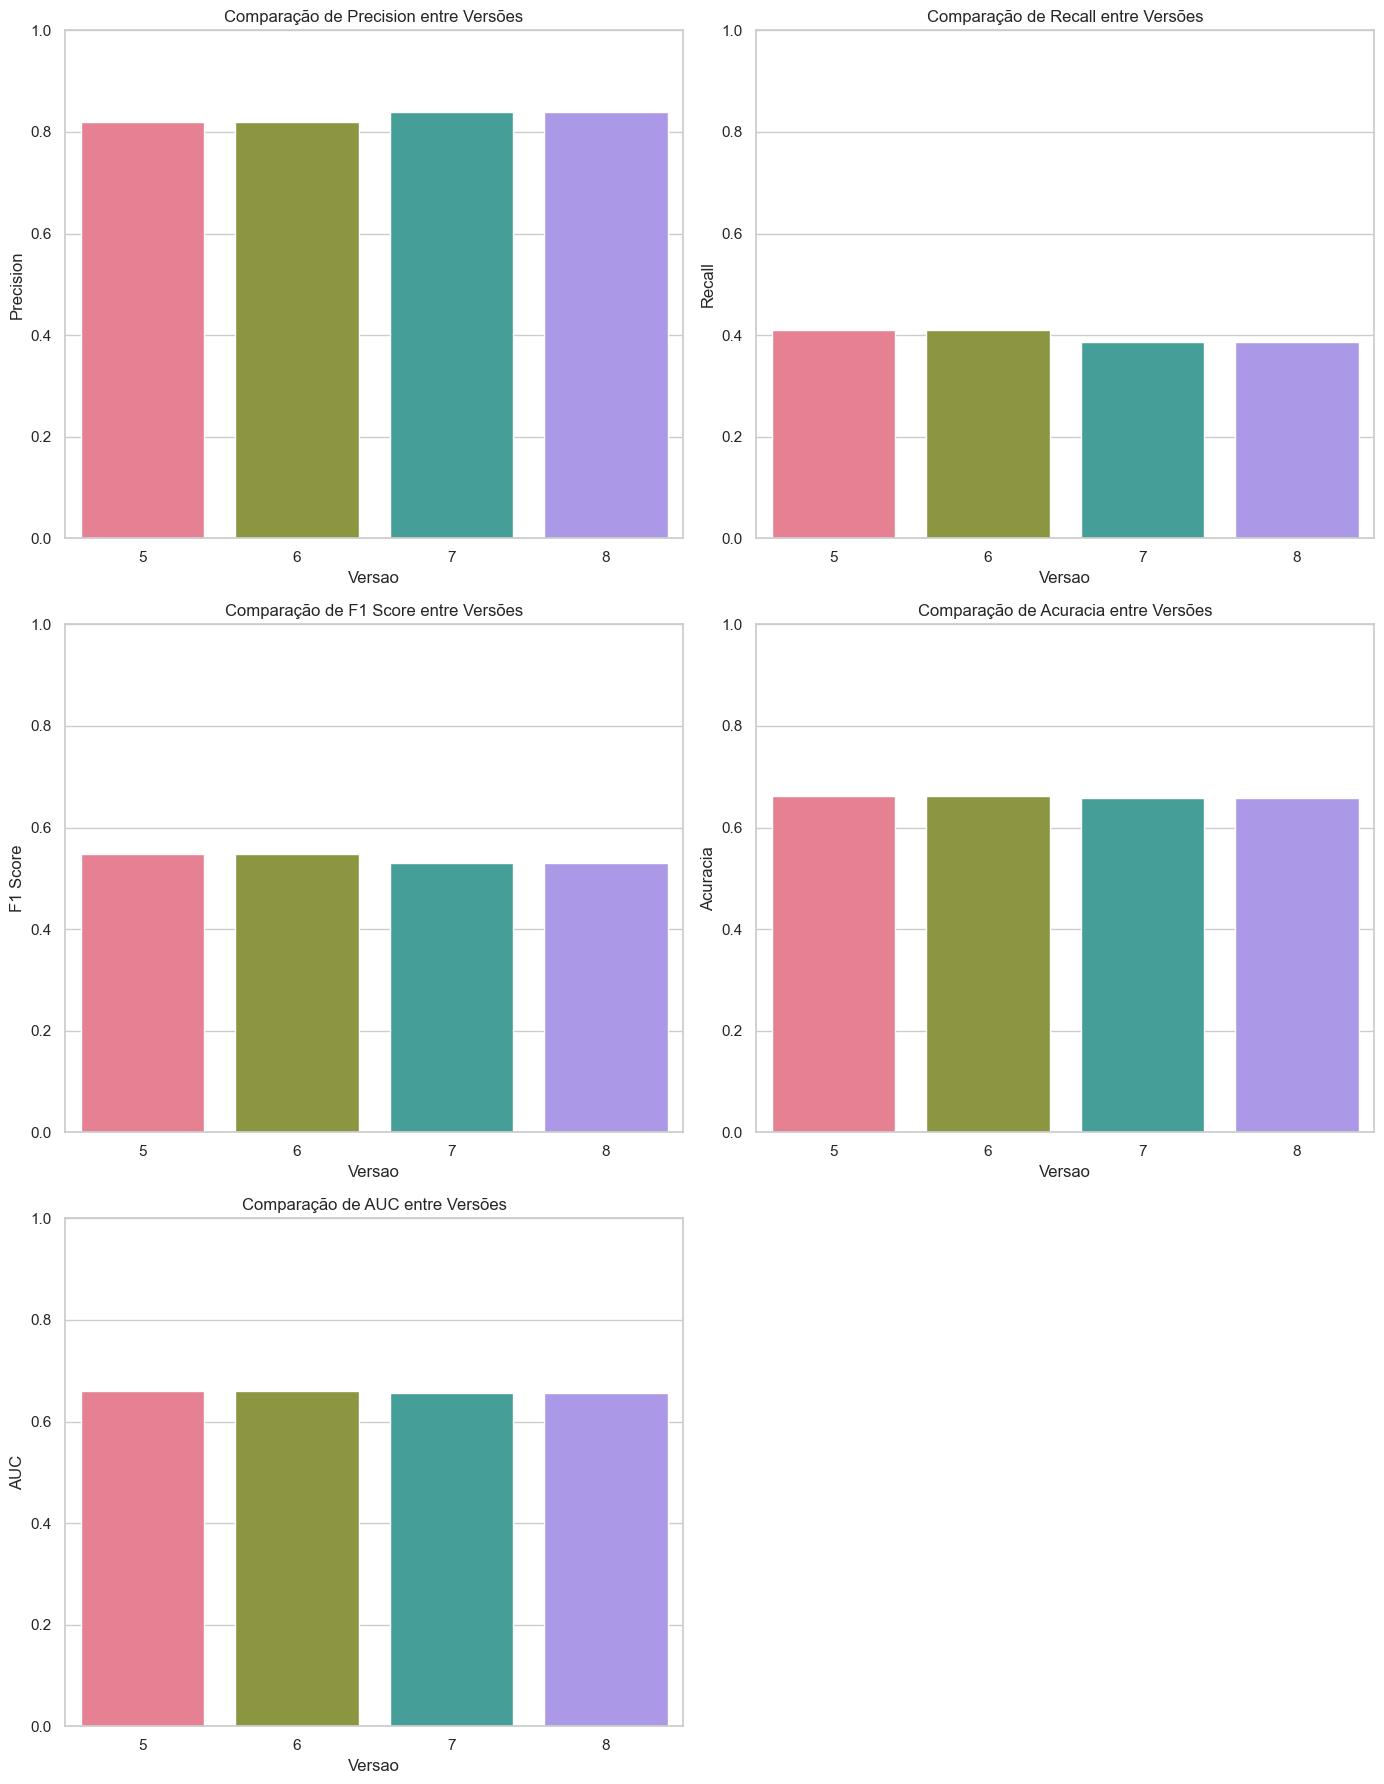

In [104]:
# Ignorando avisos futuros
warnings.filterwarnings('ignore', category=FutureWarning)

# Dados das métricas
data = {
    'Modelo': ['XGBOOST', 'XGBOOST', 'XGBOOST', 'XGBOOST'],
    'Versao': ['5', '6', '7', '8'],
    'Precision': [0.819091, 0.819091, 0.838666, 0.838666],
    'Recall': [0.410856, 0.410856, 0.386926, 0.386926],
    'F1 Score': [0.547225, 0.547225, 0.529543, 0.529543],
    'Acuracia': [0.661308, 0.661308, 0.657513, 0.657513],
    'AUC': [0.660389, 0.660389, 0.65652, 0.65652]
}

# Convertendo os dados em um DataFrame
df_XGboost = pd.DataFrame(data)

# Configurando o estilo do seaborn
sns.set(style="whitegrid")

# Criando gráficos de barras para cada métrica
metrics = ['Precision', 'Recall', 'F1 Score', 'Acuracia', 'AUC']
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

# Definindo a paleta de cores
palette = sns.color_palette("husl", len(df_XGboost['Versao'].unique()))

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    sns.barplot(x='Versao', y=metric, data=df_XGboost, ax=ax, palette=palette)
    ax.set_title(f'Comparação de {metric} entre Versões')
    ax.set_ylim(0, 1)  # Definir o limite do eixo y de 0 a 1 para todas as métricas

# Remover o gráfico vazio
fig.delaxes(axes[2, 1])

# Ajustar layout
plt.tight_layout()

# Mostrar os gráficos
plt.show()



Observações:

Precision (Precisão):
A precisão aumentou ligeiramente de 0.819091 nas versões 5 e 6 para 0.838666 nas versões 7 e 8.
Isso indica que os modelos das versões 7 e 8 são ligeiramente melhores em identificar verdadeiros positivos entre as previsões positivas feitas.

Recall (Sensibilidade):
O recall diminuiu de 0.410856 nas versões 5 e 6 para 0.386926 nas versões 7 e 8.
Isso significa que os modelos das versões 7 e 8 identificam uma menor proporção de verdadeiros positivos entre todos os casos positivos reais.

F1 Score:
O F1 Score diminuiu de 0.547225 nas versões 5 e 6 para 0.529543 nas versões 7 e 8.
Como o F1 Score é a média harmônica da precisão e do recall, essa diminuição reflete a redução no recall.

Acurácia:
A acurácia diminuiu ligeiramente de 0.661308 nas versões 5 e 6 para 0.657513 nas versões 7 e 8.
Isso mostra que a proporção de previsões corretas entre todas as previsões feitas é um pouco menor nos modelos das versões 7 e 8.

AUC (Área sob a Curva ROC):
A AUC também diminuiu ligeiramente de 0.660389 nas versões 5 e 6 para 0.65652 nas versões 7 e 8.
A AUC mede a capacidade do modelo de distinguir entre as classes, e uma ligeira diminuição indica uma leve perda na capacidade discriminativa dos modelos das versões 7 e 8.

Interpretação:
Modelos das versões 5 e 6: Parecem ter um melhor equilíbrio entre precisão e recall, resultando em um F1 Score e AUC ligeiramente melhores do que nas versões 7 e 8. Esses modelos são melhores em identificar positivos corretamente enquanto ainda capturam uma boa proporção de verdadeiros positivos.
Modelos das versões 7 e 8: Embora tenham uma precisão ligeiramente maior, a diminuição do recall resulta em um F1 Score mais baixo. Esses modelos são mais conservadores, fazendo menos previsões positivas, mas quando o fazem, são mais precisos.

Conclusão:
Os modelos das versões 5 e 6 parecem ter um desempenho geral melhor, considerando o equilíbrio entre precisão e recall. Se o objetivo for maximizar a identificação de verdadeiros positivos (ou seja, manter um bom recall), as versões 5 e 6 seriam preferíveis. No entanto, se a prioridade for a precisão, as versões 7 e 8 poderiam ser mais adequadas, apesar do imp